In [1]:
import warnings
import numpy as np 
import pandas as pd 

import os
import torch
import torch.nn as nn 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
warnings.filterwarnings('ignore')
k=0

In [3]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from   torchtext.vocab import FastText
import nltk
from nltk import ngrams
from nltk.stem import WordNetLemmatizer as wnl


In [4]:
import torchtext.vocab as vocab
import fasttext
from torch.utils.data import Dataset ,DataLoader


In [5]:
data=pd.read_csv("/kaggle/input/question-pairs-dataset/questions.csv")

In [6]:
from keras.utils import pad_sequences

In [7]:
data['question2']=data['question2'].apply(lambda x :simple_preprocess(str(x)) )
data['question1']=data['question1'].apply(lambda x :simple_preprocess(str(x)) )

In [8]:
all_q=data['question1'].append(data['question2'],ignore_index=True)

In [9]:
a=all_q.dropna().tolist()

In [10]:
words=vocab.build_vocab_from_iterator(a)

In [11]:
data.dropna(inplace=True)

In [12]:
vocab1=words.get_stoi()


In [13]:
vocab1['<\s>']=0

In [14]:
def word_to_idx(x):
    return  [vocab1[i] for i in x]

In [15]:
data['question2']=data['question2'].apply(lambda x :word_to_idx(x) ) 
data['question1']=data['question1'].apply(lambda x :word_to_idx(x) )

In [16]:
data['question2']=data['question2'].apply(lambda x :pad_sequences([x],maxlen=212, value=0)[0] )
data['question1']=data['question1'].apply(lambda x :pad_sequences([x],maxlen=212,value=0)[0] )

In [17]:
class dataset(Dataset):
    def __init__(self,x,y,z):
         self.x=x
         self.z=z
         self.y=y
    def __len__(self):
        return len(self.x) 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx],self.z[idx]

In [18]:
x=torch.tensor(data['question2'])
y=torch.tensor(data['question1'])
z=torch.tensor(data['is_duplicate'])

In [190]:
train=dataset(x[:52224],y[:52224],z[:52224])
test=dataset(x[52224:60224],y[52224:60224],z[52224:60224])
valid=dataset(x[62224:72712],y[62224:72712],z[62224:72712])
train_set=DataLoader(train,batch_size=32,shuffle =True)
test_set=DataLoader(test,batch_size=32,shuffle =True)
valid_set=DataLoader(valid,batch_size=32,shuffle =True)

In [191]:
class sts(nn.Module):
        def __init__(self):
            super(sts,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,300,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(1,1)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :300], x2[:, 0,300:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :300], x1[:, 0,300:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()
            #x1=x1[:, -1, :].cuda() 
       
            con=torch.sum(torch.abs(x1.unsqueeze(1) - x2.unsqueeze(1)), dim=2)
            #print(con.shape)
            con=self.linear(con)
            return con.cuda()


In [193]:
import torch

def calculate_accuracy(predicted_labels, true_labels):

    predicted_labels = torch.argmax(predicted_labels, dim=1)
    # Compare predicted labels with true labels
    correct = torch.eq(predicted_labels, true_labels).float()
    # Calculate accuracy
    accuracy = torch.mean(correct)
    
    return accuracy.item()*100


In [194]:
model=sts().cuda()
loss=nn.BCEWithLogitsLoss()
optim=torch.optim.Adam(model.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [ ]:
l_train=[]
v_train=[]
for i in range(10):
    model.train()
    t_l=0
    o=0
    a_t=0
    for (a,b,c) in train_set:
        r=model(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        l=loss(r,c.unsqueeze(-1).float().cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        o+=1
#        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        print(f"\r iter {o}  train loss {l.item()} , accuracy : { k}",end='')

    
    v_l=0
    model.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r=model(a.cuda(),b.cuda())
            
            l=loss(r,c.unsqueeze(-1).float().cuda())
            v_l+=l.item()
         #   k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 1632  train loss 0.5033165216445923 , accuracy : 00
0 train loss: 0.6741868895204628 accuracy : 0.0  , valid : 0.5983926940981935 accuracy : 0.0
 iter 1632  train loss 0.5573704242706299 , accuracy : 00
1 train loss: 0.5707416122450548 accuracy : 0.0  , valid : 0.575596634298563 accuracy : 0.0
 iter 1632  train loss 0.49333369731903076 , accuracy : 0
2 train loss: 0.5144859785761904 accuracy : 0.0  , valid : 0.5597878922594757 accuracy : 0.0
 iter 881  train loss 0.46165961027145386 , accuracy : 0

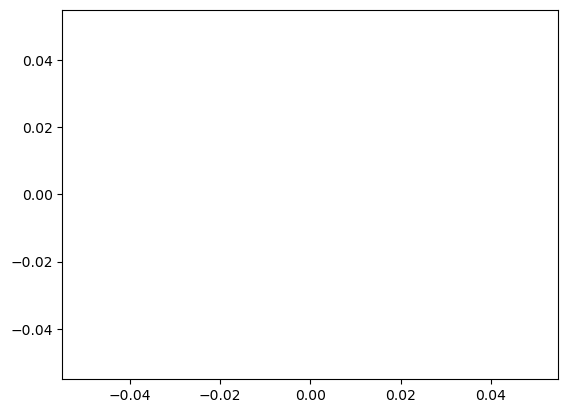

In [181]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [182]:
torch.save(model.state_dict(),'model.pth')
torch.save(model.state_dict(),'model.pth')

In [183]:
def test_classification2(device="cuda"):


        v_l=0
        model.eval()
        print()
        a_v=0
        with torch.no_grad():

            for (a,b,c) in test_set:
                r=model(a.cuda(),b.cuda())

                l=loss(r,c.unsqueeze(-1).float().cuda())
                v_l+=l.item()
             #   k=calculate_accuracy(r,c.cuda())
                a_v+=k
        schedular.step(v_l)
        l_train.append(t_l)
        v_train.append(v_l)
        print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")
test_classification2()


0 train loss: 1.2689590786184584 accuracy : 0.0  , valid : 0.7141668424010277 accuracy : 0.0


# model of cosing similarty

In [187]:
class sts_cosin(nn.Module):
        def __init__(self):
            super(sts_cosin,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,300,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(1,1)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :300], x2[:, 0,300:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :300], x1[:, 0,300:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()    
       
            #print(con.shape)
            return x2,x1
        def exponent_neg_manhattan_distance(self, x1, x2):
          return torch.exp(-torch.sum(torch.abs(x1 - x2), dim=1)).cuda()

In [188]:
model2=sts_cosin().cuda()
loss=nn.CosineEmbeddingLoss()

optim=torch.optim.NAdam(model2.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [189]:
l_train=[]
v_train=[]
for i in range(10):
    model2.train()
    t_l=0
    o=0
    a_t=0
    k=0
    for (a,b,c) in train_set:
        r,t=model2(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        c=(c-.1).sign()
        l=loss(r,t,c.cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        o+=1
#        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        
        print(f"\r iter {o}  train loss {l.item()} , accuracy : { k}",end='')
    
    v_l=0
    model2.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r,t=model2(a.cuda(),b.cuda())
            c=(c-.1).sign()

            l=loss(r,t,c.cuda())
            v_l+=l.item()
         #   k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 53  train loss 0.3950374126434326 , accuracy : 00

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [ ]:
torch.save(model2,'model2.pt')
torch.save(model2,'model2.pt')

In [173]:
def test_classification2(device="cuda"):
            v_l=0
            model2.eval()
            print()
            a_v=0
            with torch.no_grad():

                for (a,b,c) in test_set:
                    r,t=model2(a.cuda(),b.cuda())
                    c=(c-.1).sign()

                    l=loss(r,t,c.cuda())
                    v_l+=l.item()
                 #   k=calculate_accuracy(r,c.cuda())
                    a_v+=k
            schedular.step(v_l)
            l_train.append(t_l)
            v_train.append(v_l)
            print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")
test_classification2()


0 train loss: 6.254912349155971 accuracy : 0.0  , valid : 12.22688090801239 accuracy : 0.0


In [154]:
import torch.nn.functional as F


In [164]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [165]:
class sts_contrastive(nn.Module):
        def __init__(self):
            super(sts_contrastive,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,300,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(300*2,20)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :300], x2[:, 0,300:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :300], x1[:, 0,300:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()
            #x1=x1[:, -1, :].cuda() 
            x1= self.linear(x1).cuda()
            x2=self.linear(x2).cuda()
            #print(con.shape)
            return x2,x1

In [166]:
model3=sts_contrastive().cuda()
loss=ContrastiveLoss()
optim=torch.optim.Adam(model3.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [167]:
l_train=[]
v_train=[]
for i in range(10):
    model3.train()
    t_l=0
    o=0
    a_t=0
    for (a,b,c) in train_set:
        r,t=model3(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        l=loss(r,t,c.unsqueeze(-1).cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        o+=1
#        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        
        print(f"\r iter {o}  train loss {l.item()} ",end='')
    
    v_l=0
    model3.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r,t=model3(a.cuda(),b.cuda())
            c=c.sign()

            l=loss(r,t,c.unsqueeze(-1).cuda())
            v_l+=l.item()
         #   k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 30  train loss 1.3370888233184814 

KeyboardInterrupt: 

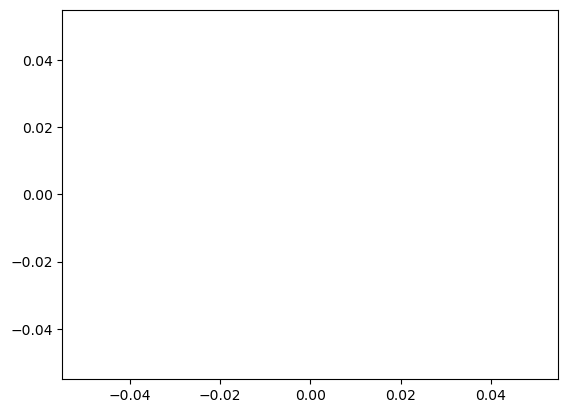

In [168]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [169]:
torch.save(model3,'model3.pt')
torch.save(model3,'model3.pt')

In [170]:
def test_classification2(device="cuda"):
    
    v_l=0
    model3.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in test_set:
            r,t=model3(a.cuda(),b.cuda())
            c=c.sign()

            l=loss(r,t,c.unsqueeze(-1).cuda())
            v_l+=l.item()
         #   k=calculate_accuracy(r,c.cuda())
            a_v+=k
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")
test_classification2()


0 train loss: 0.49707172172410147 accuracy : 0.0  , valid : 1.2123919017612934 accuracy : 0.0


In [133]:
class sts_cat(nn.Module):
        def __init__(self):
            super(sts_cat,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,500,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(1000,16)
            self.linear1=nn.Linear(16,2)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :500], x2[:, 0,500:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :500], x1[:, 0,500:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()
            #x1=x1[:, -1, :].cuda() 
            x1= self.linear(x1)
            x2= self.linear(x2)

            x1=x1*x2
            #print(con.shape)
            x1=self.linear1(x1)
            return x1

In [134]:
model4=sts_cat().cuda()
loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model4.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [135]:
l_train=[]
v_train=[]
for i in range(10):
    model4.train()
    t_l=0
    o=0
    a_t=0
    for (a,b,c) in train_set:
        r=model4(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        l=loss(r,c.cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        
        o+=1
        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        
        print(f"\r iter {o}  train loss {l.item()} , accuracy : { k}",end='')
    
    v_l=0
    model4.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r=model4(a.cuda(),b.cuda())

            l=loss(r,c.cuda())
            v_l+=l.item()
            k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 70  train loss 0.6311352252960205 , accuracy : 62.575
0 train loss: 0.6507208398410252 accuracy : 62.098214285714285  , valid : 0.6691283471882343 accuracy : 60.15625
 iter 70  train loss 0.4772574305534363 , accuracy : 81.2555
1 train loss: 0.5983139336109161 accuracy : 68.08035714285714  , valid : 0.668670266866684 accuracy : 63.28125
 iter 70  train loss 0.3839237689971924 , accuracy : 75.0055
2 train loss: 0.5163739246981485 accuracy : 74.375  , valid : 0.6881391406059265 accuracy : 65.625
 iter 70  train loss 0.5717092156410217 , accuracy : 75.0255
3 train loss: 0.3991841667464801 accuracy : 81.875  , valid : 0.7422762513160706 accuracy : 64.84375
 iter 70  train loss 0.26808837056159973 , accuracy : 93.755
4 train loss: 0.27521305478044916 accuracy : 89.28571428571429  , valid : 0.8460932075977325 accuracy : 58.7890625
 iter 70  train loss 0.10932323336601257 , accuracy : 93.755
5 train loss: 0.1686117437801191 accuracy : 93.30357142857143  , valid : 1.270208328962326 accur

In [ ]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [ ]:
torch.save(model4,'model4.pt')
torch.save(model4,'model4.pt')

In [140]:
def test_classification4(device="cuda"):
    v_l=0
    model4.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in test_set:
            r=model4(a.cuda(),b.cuda())

            l=loss(r,c.cuda())
            v_l+=l.item()
            k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")
test_classification4()


14 train loss: 0.0011689207254676147 accuracy : 100.0  , valid : 2.4841220378875732 accuracy : 62.3046875


In [121]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def change(x):
    return torch.tensor(pad_sequences([[vocab1[i]  for i in simple_preprocess(x) ]] ,maxlen=212,value=0))

In [71]:
inx_word=dict()
for label,value in vocab1.items():
    inx_word[value]=label

# model 1

In [186]:
s=nn.Sigmoid()
q1='what is mean of the life'
q2='how old the life is'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
l=len(q1)
idx=model(q1,q2)
print(s(idx))  
q1='how old are you'
q2='what is your age'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
l=len(q1)
idx=model(q1,q2)
print(s(idx)) 
q1='why are the humean die'
q2='why when i wake up i think i am died'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
idx=model(q1,q2)
print(s(idx)) 

tensor([[0.3848]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.4051]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.4009]], device='cuda:0', grad_fn=<SigmoidBackward0>)


# Model 2

In [174]:
q1='why are the humean die'
q2='why when i wake up i think i am died'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w,w2=model2(q1,q2)
idx=nn.functional.cosine_similarity(w,w2)
print(idx) 
q1='what is mean of the life'
q2='how old the life is'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w,w2=model2(q1,q2)
idx=nn.functional.cosine_similarity(w,w2)
print(idx) 
q1='how old are you'
q2='what is your age'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w,w2=model2(q1,q2)
idx=nn.functional.cosine_similarity(w,w2)
print(idx) 

tensor([0.2279], device='cuda:0', grad_fn=<SumBackward1>)
tensor([0.5520], device='cuda:0', grad_fn=<SumBackward1>)
tensor([-0.0040], device='cuda:0', grad_fn=<SumBackward1>)


# model 3 

In [104]:
q1='why are the humean die'
q2='why when i wake up i think i am died'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w,w2=model3(q1,q2)
print(F.pairwise_distance(w,w2) )
q1='what is mean of the life'
q2='how old the life is'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w,w2=model3(q1,q2)
print(F.pairwise_distance(w,w2) )
q1='how old are you'
q2='what is your age'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w,w2=model3(q1,q2)
print(F.pairwise_distance(w,w2) )

tensor([0.4322], device='cuda:0', grad_fn=<NormBackward1>)
tensor([0.2521], device='cuda:0', grad_fn=<NormBackward1>)
tensor([0.8063], device='cuda:0', grad_fn=<NormBackward1>)


In [123]:
q1='why are the humean die'
q2='why when i wake up i think i am died'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w=model4(q1,q2)
print(torch.argmax(w))  
q1='what is mean of the life'
q2='how old the life is'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w=model4(q1,q2)
print(torch.argmax(w)) 
q1='how old are you'
q2='what is your age'
q1=change(q1).cuda()
q2=change(q2).cuda()
q1=torch.tensor(q1).cuda()
q2=torch.tensor(  q2  ).cuda()
l=len(q1)
w=model4(q1,q2)
print(torch.argmax(w)) 

tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
